# Getting started with tskit
This is the step-by-step tutorial found [here](https://tskit.dev/tutorials/getting_started.html). Here we generate an alignment using [msprime](https://tskit.dev/msprime/docs/stable/intro.html), which is a python package to generate data to be used with *tskit* stuff

> A number of different software programs can generate tree sequences. For the purposes of this tutorial we’ll use msprime to create an example tree sequence representing the genetic genealogy of a 10Mb chromosome in twenty diploid individuals. To make it a bit more interesting, we’ll simulate the effects of a selective sweep in the middle of the chromosome, then throw some neutral mutations onto the resulting tree sequence.

In [1]:
import msprime

pop_size=10_000
seq_length=10_000_000

sweep_model = msprime.SweepGenicSelection(
    position=seq_length/2, start_frequency=0.0001, end_frequency=0.9999, s=0.25, dt=1e-6)

ts = msprime.sim_ancestry(
    20,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=pop_size,
    sequence_length=seq_length,
    recombination_rate=1e-8,
    random_seed=1234,  # only needed for repeatabilty
    )
# Optionally add finite-site mutations to the ts using the Jukes & Cantor model, creating SNPs
ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=4321)
ts

We have tousand of trees in `ts` object. We have *20 dyploid* individuals, so 40 nodes (one for genome? have I *two* genomes per individual as described by the tutorial?)

## Processing trees

Iterate over the *trees* with the `trees()` method:

In [2]:
for tree in ts.trees():
    print(f"Tree {tree.index} covers {tree.interval}")
    if tree.index >= 4:
        print("...")
        break
print(f"Tree {ts.last().index} covers {ts.last().interval}")

Tree 0 covers Interval(left=0.0, right=661.0)
Tree 1 covers Interval(left=661.0, right=3116.0)
Tree 2 covers Interval(left=3116.0, right=4451.0)
Tree 3 covers Interval(left=4451.0, right=4673.0)
Tree 4 covers Interval(left=4673.0, right=5020.0)
...
Tree 11166 covers Interval(left=9999635.0, right=10000000.0)


There are also `last()` and `first()` methods to access to the *last* and *first* trees respectively. Check if trees coalesce (not always true for [forward simulations](https://tskit.dev/tutorials/forward_sims.html#sec-tskit-forward-simulations))

In [3]:
import time
elapsed = time.time()
for tree in ts.trees():
    if tree.has_multiple_roots:
        print("Tree {tree.index} has not coalesced")
        break
else:
    elapsed = time.time() - elapsed
    print(f"All {ts.num_trees} trees coalesced")
    print(f"Checked in {elapsed:.6g} secs")

All 11167 trees coalesced
Checked in 0.0355113 secs


Now that we know all trees have coalesced, we know that at each position in the 
genome all the 40 sample nodes must have one most recent common ancestor (MRCA). 
Below, we iterate over the trees, finding the IDs of the root (MRCA) node for e
ach tree. The time of this root node can be found via the `tskit.TreeSequence.node()`
method, which returns a `Node` object whose attributes include the node time:

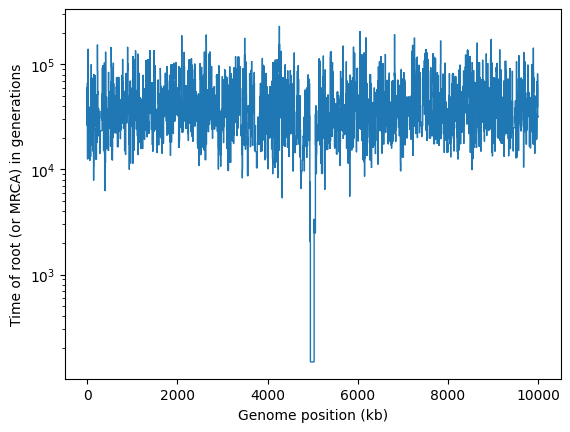

In [4]:
import matplotlib.pyplot as plt

kb = [0]  # Starting genomic position
mrca_time = []
for tree in ts.trees():
    kb.append(tree.interval.right/1000)  # convert to kb
    mrca = ts.node(tree.root)  # For msprime tree sequences, the root node is the MRCA
    mrca_time.append(mrca.time)
plt.stairs(mrca_time, kb, baseline=None)
plt.xlabel("Genome position (kb)")
plt.ylabel("Time of root (or MRCA) in generations")
plt.yscale("log")
plt.show()

It’s obvious that there’s something unusual about the trees in the middle of
this chromosome, where the selective sweep occurred.

Although tskit is designed so that is it rapid to pass through trees sequentially,
it is also possible to pull out individual trees from the middle of a tree sequence
via the `TreeSequence.at()` method. Here’s how you can use that to extract the 
tree at location - the position of the sweep - and draw it using the `Tree.draw_svg()`
method:

Tree number 5382, which runs from position 4998293.0 to 5033047.0:


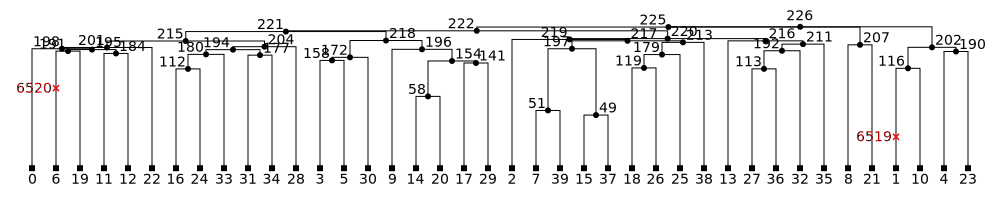

In [5]:
swept_tree = ts.at(5_000_000)  # or you can get e.g. the nth tree using ts.at_index(n)
intvl = swept_tree.interval
print(f"Tree number {swept_tree.index}, which runs from position {intvl.left} to {intvl.right}:")
# Draw it at a wide size, to make room for all 40 tips
swept_tree.draw_svg(size=(1000, 200))

This tree shows the classic signature of a recent expansion or selection event,
with many long terminal branches, resulting in an excess of singleton mutations.

It can often be helpful to slim down a tree sequence so that it represents the
genealogy of a smaller subset of the original samples. This can be done using
the powerful `TreeSequence.simplify()` method.

The `TreeSequence.draw_svg()` method allows us to draw more than one tree:
either the entire tree sequence, or (by using the `x_lim` parameter) a smaller
region of the genome:

Genealogy of the first 10 samples for the first 5kb of the genome


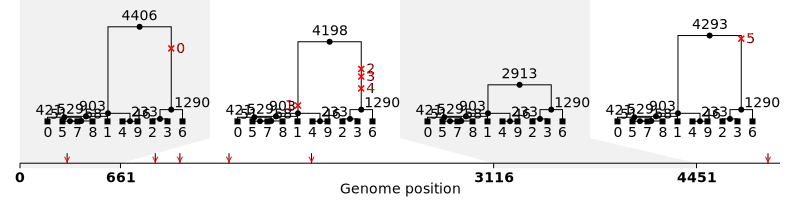

In [6]:
reduced_ts = ts.simplify([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # simplify to the first 10 samples
print("Genealogy of the first 10 samples for the first 5kb of the genome")
reduced_ts.draw_svg(x_lim=(0, 5000))

These are much more standard-looking coalescent trees, with far longer branches
higher up in the tree, and therefore many more mutations at higher-frequencies.

> In this tutorial we refer to objects, such as sample nodes, by their numerical
> IDs. These can change after simplification, and it is often more meaningful
> to [work with metadata](https://tskit.dev/tutorials/metadata.html#sec-tutorial-metadata), 
> such as sample and population names, which can be permanently attached to
> objects in the tree sequence. Such metadata is often incorporated automatically
> by the tools generating the tree sequence.